In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import glob
import pandas as pd
import numpy as np

In [ ]:

TIME_PERIOD = 1e9
TYPE_NAMES = ['O','C','D','E']
PID_OFFSET = 1e4

LOGDIR  = '/content/drive/MyDrive/IEEE/logs/'
DATADIR = '/content/drive/MyDrive/IEEE/data/'

In [ ]:
def counts(df):
  ts = df['TS'] #timestamp
  df1 = df.assign(PERIOD=np.trunc((ts - ts[0]) / TIME_PERIOD))
  df1.drop(columns=['TS', 'FLAG', 'OPEN', 'CREATE', 'DELETE', 'ENCRYPT', 'FILENAME'], inplace=True)
      # count the number of event grouped by type, period and PID and move TYPE to column
  grouped = df1.groupby(['TYPE', 'PERIOD', 'PID']).agg(['count','sum']).unstack(level='TYPE', fill_value=0)

  # aggregate over time period (max per period + total)
  aggregated = grouped.groupby(level='PID').agg(['max','sum'])

  # rename levels/columns (skip 'PATTERN')
  aggregated.columns = aggregated.columns.to_flat_index()
  aggregated.rename(columns={col: '_'.join(col[1:]) for col in aggregated.columns}, inplace=True)

  # sum the number of pattern matches across events
  pattern_max = re.compile("^sum_\w+_max$")
  pattern_sum = re.compile("^sum_\w+_sum$")
  pattern_max_cols = [col for col in aggregated.columns if pattern_max.match(col)]
  pattern_sum_cols = [col for col in aggregated.columns if pattern_sum.match(col)]
  aggregated['P_max'] = aggregated[pattern_max_cols].sum(axis=1)
  aggregated['P_sum'] = aggregated[pattern_sum_cols].sum(axis=1)
  aggregated.drop(columns=pattern_max_cols + pattern_sum_cols, inplace=True)

  # strip "count_" from columns starting with count
  aggregated.rename(columns={col: col[6:] for col in aggregated.columns if col.startswith('count')}, inplace=True)

  return aggregated


def sequences(df):
  df1 = df.drop(columns=['FLAG', 'PATTERN', 'OPEN', 'CREATE', 'DELETE', 'ENCRYPT', 'FILENAME'])

  # count the number of event type sequences (length 3)
  df1['NEXT'] = df1.groupby(['PID'])['TYPE'].transform(lambda col: col.shift(-1, fill_value='X'))
  df1['AFTER'] = df1.groupby(['PID'])['TYPE'].transform(lambda col: col.shift(-2, fill_value='X'))
  df1['SEQUENCE'] = df1[['TYPE', 'NEXT', 'AFTER']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

  print(df1.head(5))
  aggregated = df1.groupby(['PID', 'SEQUENCE'])['TS'].agg('count').unstack(level='SEQUENCE', fill_value=0)

  # drop dummy sequences (containing X)
  aggregated.drop(columns=[col for col in aggregated.columns if 'X' in col], inplace=True)

  return aggregated

In [ ]:
for dir in ['training', 'testing']:
      # sort to keep PIDs unchanged when adding files
  logs = sorted((os.listdir(LOGDIR + dir)))

  # PID collision fix (offset)
  df_arr = []
  for i,log in enumerate(logs):
      logpath = LOGDIR + dir + '/' + log
      df = pd.read_csv(logpath)
      df['PID'] = df['PID'].map(lambda x: x + i * PID_OFFSET)
      # df['FILE'] = log
      df_arr.append(df)

  df = pd.concat(df_arr, ignore_index=True, verify_integrity=True)

  df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)
  c = counts(df)
  s = sequences(df)

  combined = pd.concat([c, s], axis=1)
  pd.set_option('display.max_rows', None)

  # save to csv
  combined.to_csv(DATADIR + dir + '_data_1.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/IEEE/logs/training'

In [ ]:
df.head(10)

,TS,PID,TYPE,FLAG,PATTERN,OPEN,CREATE,DELETE,ENCRYPT,FILENAME
0,4749967602141290,2930761.0,O,1,0,0,1,0,1,/sys/kernel/debug/tracing/events/syscalls/sys_...
1,4749967607195209,2930761.0,O,1,0,0,1,0,1,/sys/kernel/debug/tracing/events/syscalls/sys_...
2,4749967607588371,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1
3,4749967608897069,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1
4,4749967608907244,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1
5,4749967609788643,2930761.0,O,0,0,0,0,0,0,/sys/bus/event_source/devices/uprobe/type
6,4749967609807119,2930761.0,O,0,0,0,0,0,0,/sys/bus/event_source/devices/uprobe/format/re...
7,4749967628705499,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1
8,4749967628798921,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1
9,4749967628806620,2930761.0,O,0,0,0,0,0,0,/opt/vagrant/embedded/lib64/libcrypto.so.1.1


In [ ]:
s.head(10)

SEQUENCE,CCC,CCD,CCO,CDC,CDD,CDO,COC,COD,COO,DCC,...,OCC,OCD,OCO,ODC,ODD,ODO,OEE,OOC,OOD,OOO
PID,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,263,0,...,0,0,262,0,138,49,0,258,60,75945
961.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2113
962.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,55
993.0,4,2,8,2,1,0,0,0,9,2,...,8,1,0,1,1,0,0,9,1,140
1312.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1336.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1368.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,445
1604.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,586
10001.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,164


In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from joblib import dump, load

In [ ]:
d1 = pd.read_csv(DATADIR + 'training_labels.csv')
d2 = pd.read_csv(DATADIR + 'testing_labels.csv')
pd.concat([d1,d2], ignore_index=True).to_csv(DATADIR + 'labels_1.csv')

In [ ]:
FILES = {
    'training': {
        'data':     DATADIR + 'training_data_1.csv',
        'labels':   DATADIR + 'training_labels.csv',
        'new_data': DATADIR + 'data_1.csv',
        'new_labels': DATADIR + 'labels_1.csv',
    },
    'testing': {
        'data':     DATADIR + 'testing_data_1.csv',
        'labels':   DATADIR + 'testing_labels.csv',
    },
    'model': {
        'features': DATADIR + 'features.joblib',
        'scaler':   DATADIR + 'scaler.joblib',
        'model':    DATADIR + 'model.joblib',
        'results':  DATADIR + 'results.png',
        'analysis': DATADIR + 'analysis.png',
    },
}

In [ ]:
def get_labels(df, file):
    if file:
        pids = pd.read_csv(file)
        pids['y'] = 1
        return df.join(pids.set_index('PID'), on='PID').fillna(0)['y']
    else:
        return df['C_max'].map(lambda x: 1 if x > 100 else 0)

def best_features_linear(coef, feature_names):
    abs_coef = abs(*coef)
    importance, feature_names = zip(*sorted(zip(abs_coef, feature_names)))
    plt.barh(range(len(feature_names)), importance, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.savefig(FILES['model']['analysis'])

def best_features_rbf(perm_importance, feature_names):
    features = np.array(feature_names)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.savefig(FILES['model']['analysis'])

def refit_strategy(cv_results):
    # print results
    df = pd.DataFrame(cv_results)
    df = df.sort_values(by=["rank_test_recall"])
    pd.set_option('display.max_colwidth', 100)
    print(df[["params", "rank_test_recall", "rank_test_balanced_accuracy", "mean_test_recall", "mean_test_balanced_accuracy"]])

    # select the highest ranked
    return df["rank_test_recall"].idxmin()

def train(file):
    X_train = pd.read_csv(FILES['training']['data'])
    y_train = get_labels(X_train, file)


    # get rid of PID column, dont use for training
    X_train.drop(columns=['PID'], inplace=True)

    # save the features in the training dataset
    dump(X_train.columns, FILES['model']['features'])

    # scale the training data
    scaler = StandardScaler().fit(X_train)
    dump(scaler, FILES['model']['scaler'])

    scaler.transform(X_train)

    # SVM classifier

    # grid search SVM hyper parameters
    kernel = ['rbf'] # 'rbf' or 'linear'
    class_weight = [{1: w} for w in np.linspace(10, 200, 10)]
    C = np.logspace(-1, 0, 10)
    param_grid = dict(class_weight=class_weight, kernel=kernel, C=C)
    scores = ['recall', 'balanced_accuracy']
    grid = GridSearchCV(svm.SVC(max_iter=1_000_000), param_grid=param_grid, scoring=scores, refit=refit_strategy)
    grid.fit(X_train, y_train)

    best_classifier = grid.best_estimator_

    dump(best_classifier, FILES['model']['model'])

    score = best_classifier.score(X_train, y_train)
    print("Training score: %f" % score)

    feature_names = X_train.columns.to_list()
    if kernel[0] == 'linear':
        best_features_linear(best_classifier.coef_, feature_names)
    elif kernel[0] == 'rbf':
        best_features_rbf(permutation_importance(best_classifier, X_train, y_train), feature_names)


def rf_train(file):
    X_train = pd.read_csv(FILES['training']['data'])
    y_train = get_labels(X_train, file)

    if len(X_train) < len(y_train):
        X_train = X_train.iloc[:len(y_train)]
    elif len(X_train) > len(y_train):
        y_train = y_train.iloc[:len(X_train)]


    # get rid of PID column, dont use for training
    X_train.drop(columns=['PID'], inplace=True)

    # save the features in the training dataset
    dump(X_train.columns, FILES['model']['features'])

    # scale the training data
    scaler = StandardScaler().fit(X_train)
    dump(scaler, FILES['model']['scaler'])

    scaler.transform(X_train)

    param_grid ={
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 8],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    }

    scores = ['recall', 'balanced_accuracy']
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        scoring=scores,
        refit='balanced_accuracy'
    )
    grid.fit(X_train, y_train)

    # Save the best Random Forest classifier
    best_classifier = grid.best_estimator_
    dump(best_classifier, FILES['model']['model'])

    # Evaluate the model on the training data
    score = best_classifier.score(X_train, y_train)
    print("Training score: %f" % score)

    # Feature importance analysis
    feature_names = X_train.columns.to_list()
    importances = best_classifier.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]

    print("Top features:")
    for i in sorted_indices[:10]:  # Print the top 10 features
        print(f"{feature_names[i]}: {importances[i]:.4f}")


def xgtrain(file):
  X_train = pd.read_csv(FILES['training']['data'])
  y_train = get_labels(X_train, file)

  # Remove PID column
  X_train.drop(columns=['PID'], inplace=True)

  # Save feature names
  dump(X_train.columns, FILES['model']['features'])

  # Scale the data
  scaler = StandardScaler().fit(X_train)
  dump(scaler, FILES['model']['scaler'])

  X_train = scaler.transform(X_train)

  # Split the data into training and validation sets

  # Define hyperparameter grid for XGBoost
  param_grid = {
      'n_estimators': [50, 100, 200],
      'max_depth': [3, 5, 7,8],
      'learning_rate': [0.01, 0.05, 0.1, 0.2],
      'subsample': [0.6, 0.8, 1.0],
      'colsample_bytree': [0.6, 0.8, 1.0],
      'scale_pos_weight': np.linspace(1, 10, 5)  # For imbalanced datasets
  }

  # Define scoring metrics
  scores = ['recall', 'balanced_accuracy']

  # Set up GridSearchCV
  grid = GridSearchCV(
      XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
      param_grid=param_grid,
      scoring=scores,
      refit='balanced_accuracy',  # Adjust refit strategy
      cv=5
  )

  # Train the XGBoost model with GridSearchCV
  grid.fit(X_train, y_train)



  # Save the best model
  best_classifier = grid.best_estimator_
  dump(best_classifier, FILES['model']['model'])

  # Feature importance analysis
  feature_names = pd.read_csv(FILES['model']['features']).tolist()
  importances = best_classifier.feature_importances_
  sorted_indices = np.argsort(importances)[::-1]

  print("Top features:")
  for i in sorted_indices[:10]:  # Print the top 10 features
      print(f"{feature_names[i]}: {importances[i]:.4f}")


def test(file):
    X_test = pd.read_csv(FILES['testing']['data'])
    y_test = get_labels(X_test, file)

    # get rid of PID column, dont use for training
    X_test.drop(columns=['PID'], inplace=True)

    # make sure to use the same features as for training
    training_features = load(FILES['model']['features'])
    test_features = X_test.columns
    # drop new features
    X_test.drop(columns=[f for f in test_features if f not in training_features], inplace=True)
    # add missing features
    for f in training_features:
        if f not in test_features:
            X_test[f] = 0

    # scale the test data
    scaler = load(FILES['model']['scaler'])
    scaler.transform(X_test)

    # predict with the previously trained classifier
    classifier = load(FILES['model']['model'])

    score = classifier.score(X_test, y_test)
    print("Testing score: %f" % score)

    # confusion matrix
    cm_display = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

    # ROC Curve -> should use precision-recall curve instead
    roc_display = RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    cm_display.plot(ax=ax1)
    roc_display.plot(ax=ax2)
    plt.savefig(FILES['model']['results'])

def pred():
    X_test = pd.read_csv(FILES['testing']['data'])
    #y_test = get_labels(X_test, file)
    pidarr = X_test['PID']

    # get rid of PID column, dont use for training
    X_test.drop(columns=['PID'], inplace=True)

    # make sure to use the same features as for training
    training_features = load(FILES['model']['features'])
    test_features = X_test.columns
    # drop new features
    X_test.drop(columns=[f for f in test_features if f not in training_features], inplace=True)
    # add missing features
    for f in training_features:
        if f not in test_features:
            X_test[f] = 0

    # scale the test data
    scaler = load(FILES['model']['scaler'])
    scaler.transform(X_test)

    # predict with the previously trained classifier
    classifier = load(FILES['model']['model'])

    prediction = pd.DataFrame({'PID': pidarr, 'Pred': classifier.predict(X_test)})
    #pd.set_option('display.max_rows', len(prediction))
    print(prediction.to_string())

In [ ]:
rf_train(FILES['training']['labels'])

Training score: 0.988260
Top features:
COO: 0.2989
C_sum: 0.1343
COC: 0.1041
OOC: 0.0885
OCO: 0.0866
C_max: 0.0805
OCC: 0.0751
CCO: 0.0522
O_max: 0.0321
O_sum: 0.0207


Testing score: 0.994768


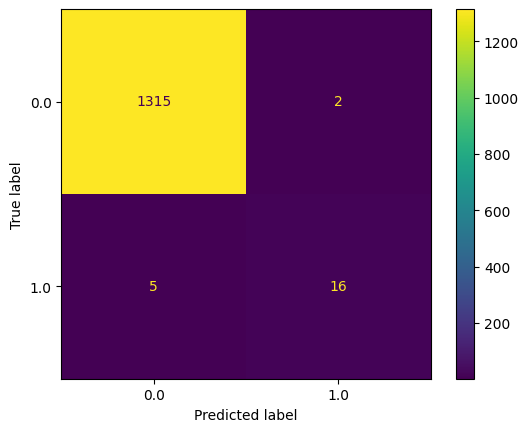

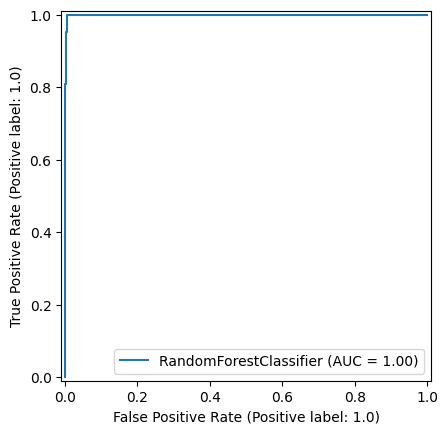

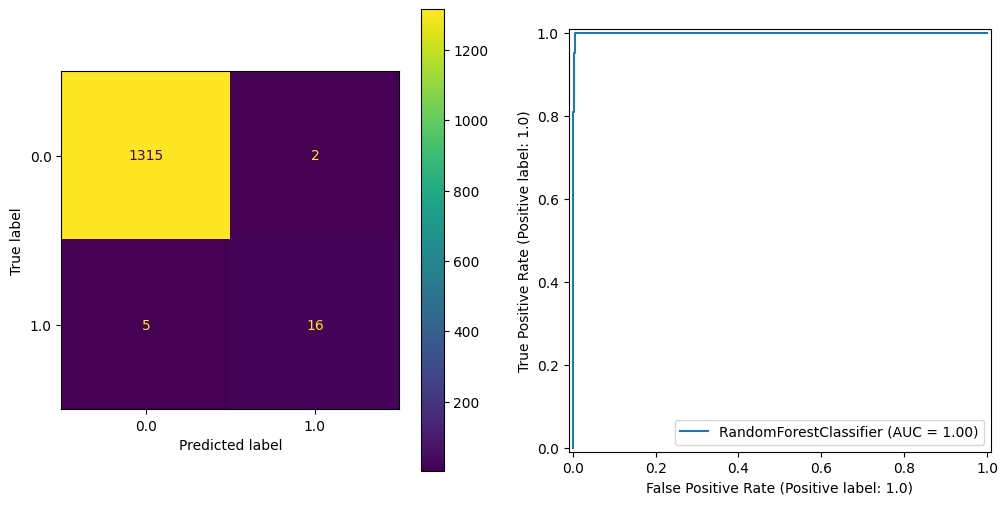

In [ ]:
test(FILES['testing']['labels'])

                                                                                  params  \
82    {'C': 0.7742636826811269, 'class_weight': {1: 52.22222222222222}, 'kernel': 'rbf'}   
83    {'C': 0.7742636826811269, 'class_weight': {1: 73.33333333333333}, 'kernel': 'rbf'}   
84    {'C': 0.7742636826811269, 'class_weight': {1: 94.44444444444444}, 'kernel': 'rbf'}   
85   {'C': 0.7742636826811269, 'class_weight': {1: 115.55555555555556}, 'kernel': 'rbf'}   
86   {'C': 0.7742636826811269, 'class_weight': {1: 136.66666666666666}, 'kernel': 'rbf'}   
87   {'C': 0.7742636826811269, 'class_weight': {1: 157.77777777777777}, 'kernel': 'rbf'}   
72    {'C': 0.5994842503189408, 'class_weight': {1: 52.22222222222222}, 'kernel': 'rbf'}   
73    {'C': 0.5994842503189408, 'class_weight': {1: 73.33333333333333}, 'kernel': 'rbf'}   
74    {'C': 0.5994842503189408, 'class_weight': {1: 94.44444444444444}, 'kernel': 'rbf'}   
75   {'C': 0.5994842503189408, 'class_weight': {1: 115.55555555555556}, 'kernel'

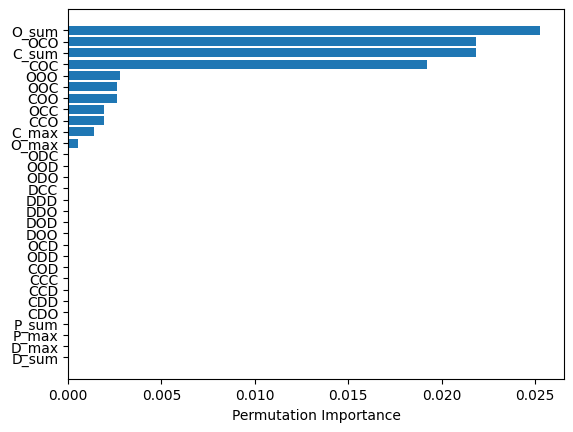

In [ ]:
train(FILES['training']['labels'])

Testing score: 0.979821


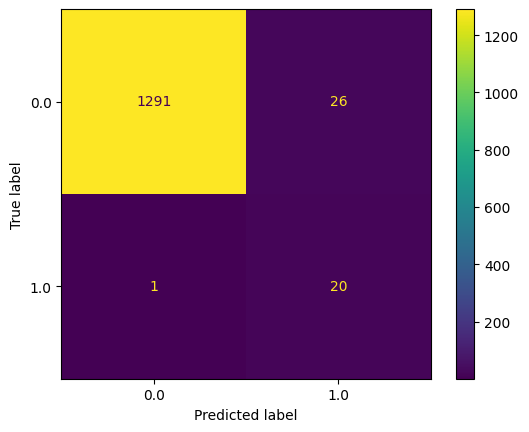

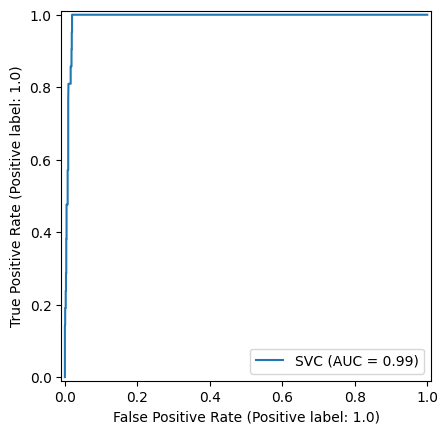

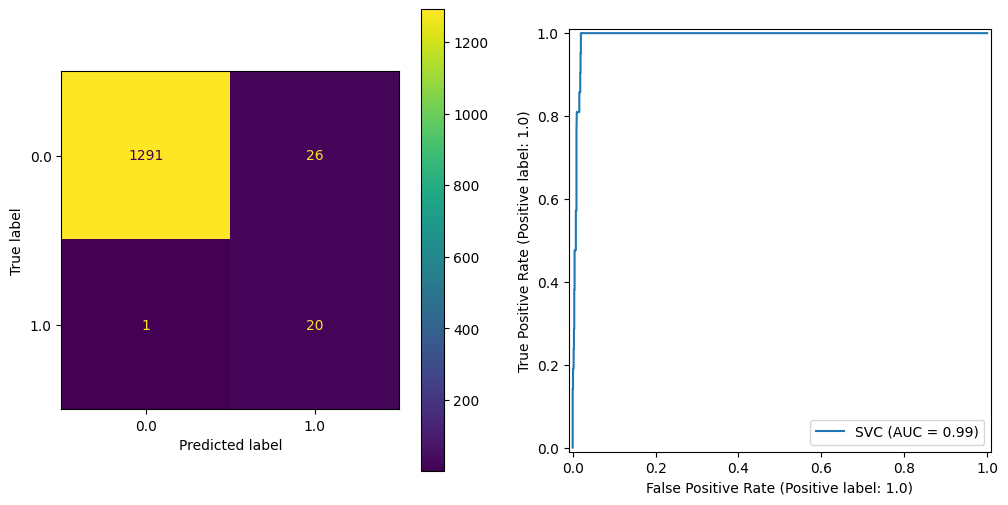

In [ ]:
test(FILES['testing']['labels'])

In [ ]:
df_arr = []
for dir in ['training', 'testing']:
      # sort to keep PIDs unchanged when adding files
  logs = sorted((os.listdir(LOGDIR + dir)))

  # PID collision fix (offset)

  for i,log in enumerate(logs):
      logpath = LOGDIR + dir + '/' + log
      df = pd.read_csv(logpath)
      df['PID'] = df['PID'].map(lambda x: x + i * PID_OFFSET)
      # df['FILE'] = log
      df_arr.append(df)

  df = pd.concat(df_arr, ignore_index=True, verify_integrity=True)

  df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)
  c = counts(df)
  s = sequences(df)

  combined = pd.concat([c, s], axis=1)
  pd.set_option('display.max_rows', None)

  # save to c
combined.to_csv(DATADIR + 'data_1.csv')

<ipython-input-16-dd519153de0e>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)


              TS     PID TYPE NEXT AFTER SEQUENCE
0  4271420984422  3695.0    O    O     O      OOO
1  4271426616202  3695.0    O    O     O      OOO
2  4271427155133  3695.0    O    O     O      OOO
3  4271427316910  3695.0    O    O     O      OOO
4  4271427326312  3695.0    O    O     O      OOO


<ipython-input-16-dd519153de0e>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)


              TS     PID TYPE NEXT AFTER SEQUENCE
0  4271420984422  3695.0    O    O     O      OOO
1  4271426616202  3695.0    O    O     O      OOO
2  4271427155133  3695.0    O    O     O      OOO
3  4271427316910  3695.0    O    O     O      OOO
4  4271427326312  3695.0    O    O     O      OOO


In [ ]:
df_arr=[]
df = pd.read_csv('log.csv')
#df['PID'] = df['PID'].map(lambda x: x + i * PID_OFFSET)
# df['FILE'] = log
df_arr.append(df)

df = pd.concat(df_arr, ignore_index=True, verify_integrity=True)

df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)
c = counts(df)
s = sequences(df)

combined = pd.concat([c, s], axis=1)
pd.set_option('display.max_rows', None)

# save to csv
combined.to_csv(DATADIR + 'fresh_data_1.csv')

<ipython-input-70-1c74ed01161b>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TYPE'].replace([0,1,2,3], TYPE_NAMES, inplace=True)


                TS      PID TYPE NEXT AFTER SEQUENCE
0  237115992982762  3554589    O    O     O      OOO
1  237115993818974  3554589    O    O     O      OOO
2  237116009742774  3554589    O    O     O      OOO
3  237116010028982  3554589    O    O     O      OOO
4  237116010304259  3554589    O    O     O      OOO


Ransomware ID: 3555102

In [ ]:
dft = pd.read_csv(DATADIR + 'fresh_data_1.csv')

In [ ]:
dft

,PID,C_max,C_sum,D_max,D_sum,O_max,O_sum,P_max,P_sum,CCC,...,DOD,DOO,OCD,OCO,ODC,ODD,ODO,OOC,OOD,OOO
0,737,0,0,140,142,68,73,0,0,0,...,1,2,0,0,0,2,1,0,2,66
1,1013,0,0,0,0,30,810,0,0,0,...,0,0,0,0,0,0,0,0,0,808
2,1054,0,0,0,0,40,70,0,0,0,...,0,0,0,0,0,0,0,0,0,68
3,3166,0,0,0,0,2,42,0,0,0,...,0,0,0,0,0,0,0,0,0,40
4,3755,0,0,0,0,19,19,0,0,0,...,0,0,0,0,0,0,0,0,0,17
5,3448288,6,9,6,9,6,9,0,0,0,...,0,0,0,0,8,0,0,0,0,0
6,3448514,0,0,0,0,20,676,0,0,0,...,0,0,0,0,0,0,0,0,0,674
7,3448870,0,0,0,0,203,941,0,0,0,...,0,0,0,0,0,0,0,0,0,939
8,3449375,0,0,0,0,3,22,0,0,0,...,0,0,0,0,0,0,0,0,0,20
9,3450662,0,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
lab = pd.DataFrame(columns=['PID'])

In [ ]:
lab.loc[len(df)] = ['3555102']

In [ ]:
lab = lab.reset_index(drop=True)

In [ ]:
lab

,PID
0,3555102


In [ ]:
lab.to_csv(DATADIR + 'fresh_label.csv',index=False)

In [ ]:
lab

,PID
0,3555102


In [ ]:
def reprep(file):
    X_test = pd.read_csv('/content/drive/MyDrive/IEEE/data/fresh_data_1.csv')
    y_test = reget_labels(X_test, file)

    # get rid of PID column, dont use for training
    X_test.drop(columns=['PID'], inplace=True)

    # make sure to use the same features as for training
    training_features = load(FILES['model']['features'])
    # drop new features
    X_test.drop(columns=[f for f in X_test.columns if f not in training_features], inplace=True)
    # add missing features
    for f in training_features:
      if f not in X_test.columns:
        #print(f)
        location = list(training_features).index(f)
        #print(location)
        X_test.insert(location, f, 0)
    print(X_test.loc[0])
    #print(X_test.columns)
    # scale the test data

    scaler = load(FILES['model']['scaler'])
    scaler.transform(X_test)

    # predict with the previously trained classifier
    classifier = load(FILES['model']['model'])

    score = classifier.score(X_test, y_test)
    print("Testing score: %f" % score)

    # confusion matrix
    cm_display = ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

    # ROC Curve -> should use precision-recall curve instead
    roc_display = RocCurveDisplay.from_estimator(classifier, X_test, y_test)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    cm_display.plot(ax=ax1)
    roc_display.plot(ax=ax2)
    plt.savefig(FILES['model']['results'])

def reget_labels(df, file):
    if file:
        pids = pd.read_csv(file)
        pids['y'] = 1
        return df.join(pids.set_index('PID'), on='PID').fillna(0)['y']
    else:
        return df['C_max'].map(lambda x: 1 if x > 100 else 0)


C_max      0
C_sum      0
D_max    140
D_sum    142
O_max     68
O_sum     73
P_max      0
P_sum      0
CCC        0
CCD        0
CCO        0
CDD        0
CDO        0
COC        0
COD        0
COO        0
DCC        0
DDD      137
DDO        2
DOD        1
DOO        2
OCC        0
OCD        0
OCO        0
ODC        0
ODD        2
ODO        1
OOC        0
OOD        2
OOO       66
Name: 0, dtype: int64
Testing score: 0.987342


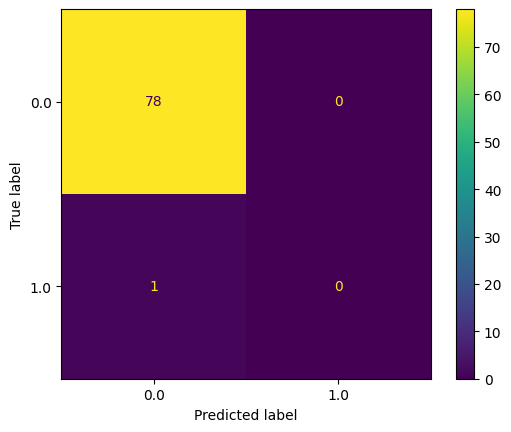

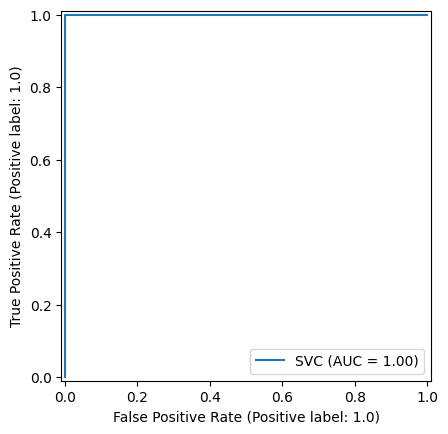

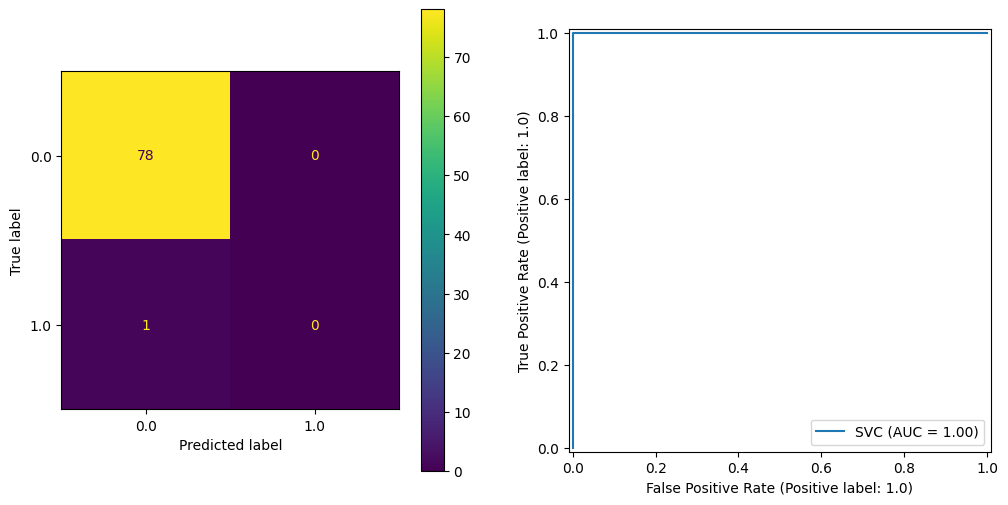

In [ ]:
reprep('/content/drive/MyDrive/IEEE/data/fresh_label.csv')

In [ ]:
print(load(FILES['model']['features']))

Index(['C_max', 'C_sum', 'D_max', 'D_sum', 'O_max', 'O_sum', 'P_max', 'P_sum',
       'CCC', 'CCD', 'CCO', 'CDD', 'CDO', 'COC', 'COD', 'COO', 'DCC', 'DDD',
       'DDO', 'DOD', 'DOO', 'OCC', 'OCD', 'OCO', 'ODC', 'ODD', 'ODO', 'OOC',
       'OOD', 'OOO'],
      dtype='object')


In [ ]:
c=0
for i in load(FILES['model']['features']):
  c+=1
print(c)

30


In [ ]:
for i in load(FILES['model']['features']):
  if i not in pd.read_csv('/content/drive/MyDrive/IEEE/data/fresh_data_1.csv').columns:
    print(i)

CCD
CCO
CDD
COC
DCC
OCC


In [ ]:
df = pd.read_csv('log.csv')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/IEEE/data/fresh_data_1.csv')

In [ ]:
len(df['PID'].value_counts())

79

In [ ]:
print(3555102 in df1['PID'].values)

True


In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(60, activation='relu', input_dim=30))
model.add(Dense(120, activation='relu'))

model.add(Dense(120, activation='relu'))

model.add(Dense(60, activation = 'sigmoid'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                     │ (None, 60)                  │           1,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 120)                 │           7,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 120)                 │          14,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 60)                  │           7,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 60)                  │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,481 (142.50 KB)

 Trainable params: 36,481 (142.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = pd.read_csv(FILES['training']['data'])
y_train = get_labels(X_train, FILES['training']['labels'])

  # Remove PID column
X_train.drop(columns=['PID'], inplace=True)
scaler = StandardScaler()
scaler.fit_transform(X_train)

array([[-0.09731943, -0.0652651 ,  0.42722374, ..., -0.06055915,
         2.27366223, -0.07604565],
       [-0.08763098, -0.06471586,  0.42722374, ..., -0.05843905,
         2.27366223,  0.14515129],
       [-0.09731943, -0.0652651 , -0.05084425, ..., -0.06055915,
        -0.1034229 , -0.11468849],
       ...,
       [-0.09731943, -0.0652651 , -0.05084425, ..., -0.06055915,
        -0.1034229 , -0.13201114],
       [-0.09731943, -0.0652651 , -0.05084425, ..., -0.06055915,
        -0.1034229 , -0.13067863],
       [-0.07794253, -0.06416661, -0.05084425, ..., -0.05843905,
        -0.1034229 ,  0.08785329]])

In [ ]:
history = model.fit(X_train, y_train, epochs = 25, batch_size = 30, validation_split=0.2, verbose = 1)

Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7753 - loss: 0.4665 - val_accuracy: 0.9931 - val_loss: 0.1273
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9905 - loss: 0.1090 - val_accuracy: 0.9931 - val_loss: 0.0720
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9924 - loss: 0.0675 - val_accuracy: 0.9931 - val_loss: 0.0580
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9902 - loss: 0.0645 - val_accuracy: 0.9931 - val_loss: 0.0537
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9864 - loss: 0.0725 - val_accuracy: 0.9931 - val_loss: 0.0501
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9905 - loss: 0.0559 - val_accuracy: 0.9931 - val_loss: 0.0458
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.0653 - val_accuracy: 0.9931 - val_loss: 0.0454
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9895 - loss: 0.0563 - val_accuracy: 0.9931 - val_loss

In [ ]:
X_test = pd.read_csv('/content/drive/MyDrive/IEEE/data/fresh_data_1.csv')
y_test = reget_labels(X_test, '/content/drive/MyDrive/IEEE/data/fresh_label.csv')

# get rid of PID column, dont use for training
X_test.drop(columns=['PID'], inplace=True)

# make sure to use the same features as for training
training_features = load(FILES['model']['features'])
# drop new features
X_test.drop(columns=[f for f in X_test.columns if f not in training_features], inplace=True)
# add missing features
for f in training_features:
  if f not in X_test.columns:
  #print(f)
    location = list(training_features).index(f)
    #print(location)
    X_test.insert(location, f, 0)

scaler.fit_transform(X_test)

array([[-0.12216676, -0.15135835,  7.50479371, ..., -0.1132277 ,
         8.83176087, -1.50697953],
       [-0.12216676, -0.15135835, -0.16079721, ..., -0.1132277 ,
        -0.1132277 ,  0.67211481],
       [-0.12216676, -0.15135835, -0.16079721, ..., -0.1132277 ,
        -0.1132277 , -1.50110596],
       ...,
       [-0.12216676, -0.15135835, -0.16079721, ..., -0.1132277 ,
        -0.1132277 ,  0.01133822],
       [-0.12216676, -0.15135835, -0.16079721, ..., -0.1132277 ,
        -0.1132277 ,  1.68236878],
       [-0.12216676, -0.15135835, -0.16079721, ..., -0.1132277 ,
        -0.1132277 ,  1.22716714]])

In [ ]:
loss, acc = model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9937 - loss: 0.0353


In [ ]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
X_test

,C_max,C_sum,D_max,D_sum,O_max,O_sum,P_max,P_sum,CCC,CCD,...,DOO,OCC,OCD,OCO,ODC,ODD,ODO,OOC,OOD,OOO
0,0,0,140,142,68,73,0,0,0,0,...,2,0,0,0,0,2,1,0,2,66
1,0,0,0,0,30,810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,808
2,0,0,0,0,40,70,0,0,0,0,...,0,0,0,0,0,0,0,0,0,68
3,0,0,0,0,2,42,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40
4,0,0,0,0,19,19,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17
5,6,9,6,9,6,9,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
6,0,0,0,0,20,676,0,0,0,0,...,0,0,0,0,0,0,0,0,0,674
7,0,0,0,0,203,941,0,0,0,0,...,0,0,0,0,0,0,0,0,0,939
8,0,0,0,0,3,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
9,0,0,0,0,1,6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
(y_pred)

array([[0.01206621],
       [0.01082582],
       [0.00864567],
       [0.01158984],
       [0.00812043],
       [0.01039584],
       [0.01085556],
       [0.01109883],
       [0.01196055],
       [0.01245444],
       [0.02477519],
       [0.01116303],
       [0.01079673],
       [0.0107067 ],
       [0.00746803],
       [0.00773602],
       [0.00439476],
       [0.00439476],
       [0.00439476],
       [0.00482482],
       [0.00454632],
       [0.00759108],
       [0.00749352],
       [0.00441205],
       [0.00439649],
       [0.00439649],
       [0.00439649],
       [0.00441014],
       [0.0080815 ],
       [0.00451619],
       [0.00439476],
       [0.00790399],
       [0.00439476],
       [0.00426337],
       [0.00427738],
       [0.00428511],
       [0.00439649],
       [0.00439649],
       [0.00441945],
       [0.00439649],
       [0.00439649],
       [0.00439476],
       [0.00439476],
       [0.00439476],
       [0.00427954],
       [0.00429584],
       [0.00442511],
       [0.007

In [ ]:
y_pred = [[0.01206621],
       [0.01082582],
       [0.00864567],
       [0.01158984],
       [0.00812043],
       [0.01039584],
       [0.01085556],
       [0.01109883],
       [0.01196055],
       [0.01245444],
       [0.02477519],
       [0.01116303],
       [0.01079673],
       [0.0107067 ],
       [0.00746803],
       [0.00773602],
       [0.00439476],
       [0.00439476],
       [0.00439476],
       [0.00482482],
       [0.00454632],
       [0.00759108],
       [0.00749352],
       [0.00441205],
       [0.00439649],
       [0.00439649],
       [0.00439649],
       [0.00441014],
       [0.0080815 ],
       [0.00451619],
       [0.00439476],
       [0.00790399],
       [0.00439476],
       [0.00426337],
       [0.00427738],
       [0.00428511],
       [0.00439649],
       [0.00439649],
       [0.00441945],
       [0.00439649],
       [0.00439649],
       [0.00439476],
       [0.00439476],
       [0.00439476],
       [0.00427954],
       [0.00429584],
       [0.00442511],
       [0.00732898],
       [0.00446815],
       [0.00439868],
       [0.00447561],
       [0.00446551],
       [0.00439519],
       [0.00439476],
       [0.00428245],
       [0.00430172],
       [0.00428002],
       [0.00439912],
       [0.00439956],
       [0.00439824],
       [0.00441157],
       [0.00439649],
       [0.00439779],
       [0.00439649],
       [0.00439476],
       [0.00436827],
       [0.01080816],
       [0.00427766],
       [0.00441014],
       [0.00439824],
       [0.00442251],
       [0.00439649],
       [0.00442097],
       [0.00439649],
       [0.00439649],
       [0.00439476],
       [0.00439476],
       [0.00427796],
       [0.00429269]]

In [ ]:
sum = 0
for i in y_pred:
    sum+=i[0]
print(sum/len(y_pred))

0.006079221392405061


In [ ]:
threshold = 0.006079 #0.0108
for i in range(len(y_pred)):
  if y_pred[i][0] >= threshold:
    y_pred[i][0] = 1
  else:
    y_pred[i][0] = 0

In [ ]:
y_test

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [ ]:
y_test =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 1.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0
, 0.0]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
confusion_matrix(y_test, y_pred)

array([[57, 21],
       [ 0,  1]])

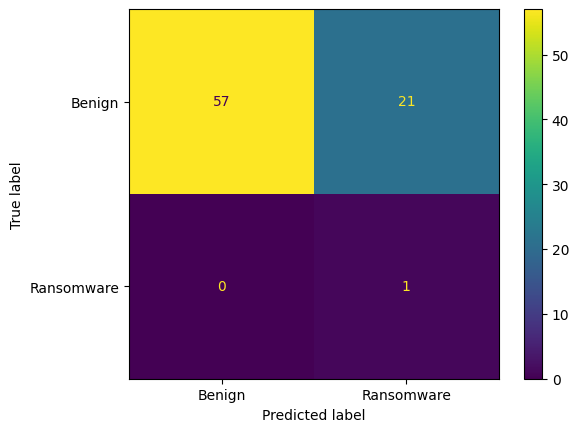

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),display_labels=['Benign', 'Ransomware']).plot()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84        78
         1.0       0.05      1.00      0.09         1

    accuracy                           0.73        79
   macro avg       0.52      0.87      0.47        79
weighted avg       0.99      0.73      0.83        79



In [ ]:
model.save()

NameError: name 'model' is not defined